## Given code

In [46]:
import numpy as np
import scipy as scipy
from scipy.linalg import toeplitz
from scipy.sparse import csr_matrix, kron

def blur(N, band=3, sigma=0.7):
    z = np.block([np.exp(-(np.array([range(band)])**2)/(2*sigma**2)), np.zeros((1, N-band))])
    A = toeplitz(z)
    A = csr_matrix(A)
    A = (1/(2*np.pi*sigma**2))*kron(A,A)
    
    x = np.zeros((N, N))
    N2 = round(N/2)
    N3 = round(N/3)
    N6 = round(N/6)
    N12 = round(N/12)
    
    # Large elipse
    T = np.zeros((N6, N3))
    for i in range(1, N6+1):
        for j in range(1, N3+1):
            if (i/N6)**2 + (j/N3)**2 < 1:
                T[i-1,j-1] = 1
    
    T = np.block([np.fliplr(T), T])
    T = np.block([[np.flipud(T)],[T]])
    x[2:2+2*N6, N3-1:3*N3-1] =  T
    
    # Small elipse
    T = np.zeros((N6, N3))
    for i in range(1, N6+1):
        for j in range(1, N3+1):
            if (i/N6)**2 + (j/N3)**2 < 0.6:
                T[i-1,j-1] = 1
    
    T = np.block([np.fliplr(T), T])
    T = np.block([[np.flipud(T)],[T]])
    x[N6:3*N6, N3-1:3*N3-1] =  x[N6:3*N6, N3-1:3*N3-1] + 2*T
    x[x==3] = 2*np.ones((x[x==3]).shape)
    
    T = np.triu(np.ones((N3,N3)))
    mT, nT = T.shape
    x[N3+N12:N3+N12+nT,1:mT+1] = 3*T
    
    T = np.zeros((2*N6+1,2*N6+1))
    mT, nT = T.shape
    T[N6,:] = np.ones((1,nT))
    T[:,N6] = np.ones((mT))
    x[N2+N12:N2+N12+mT,N2:N2+nT] = 4*T
    
    x = x[:N,:N].reshape(N**2,1)
    b = A @ x
    
    return A, b, x

## Section A

In [47]:
import matplotlib.pyplot as plt
import time

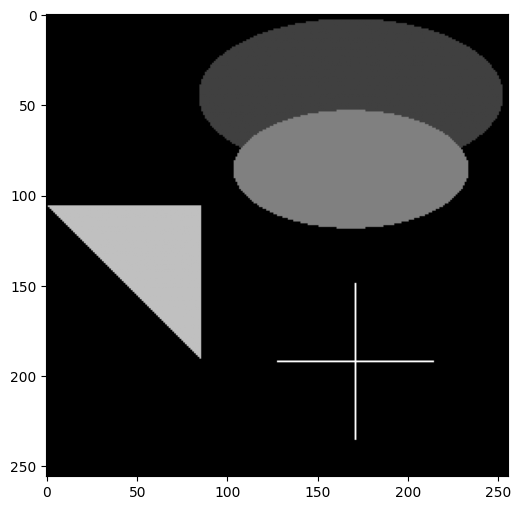

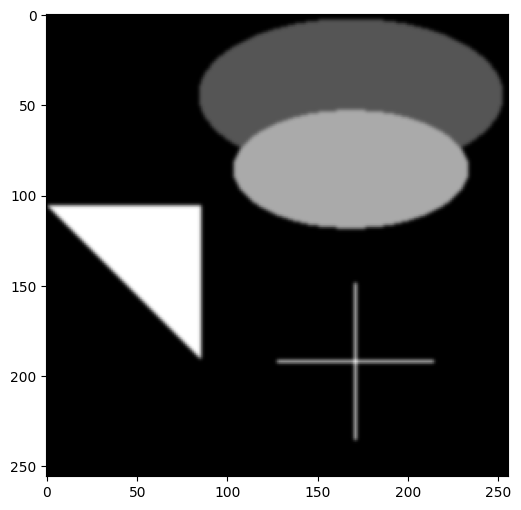

In [48]:
A,b,x = blur(256, 5, 1)
plt.figure(figsize=(6,6))
plt.imshow(x.reshape(256 ,256), cmap='gray')
plt.show()
plt.figure(figsize=(6,6))
plt.imshow(b.reshape(256 ,256), cmap='gray')
plt.show()

In [49]:
def exact_quad(A):
    def lsearch(f ,xk ,gk):
        return (np.linalg.norm(gk) ** 2) / (2 * np.linalg.norm(A.dot(gk)) ** 2)
    return lsearch


def generic_grad(f, gf, lsearch, x0, num_iter=1000):
    x = [x0]
    fs = [f(x0)]
    ts = [0]
    tic = time.time()
    i = 0
    while i < num_iter:
        g = gf(x[i])
        t = lsearch(f, x[i] ,g)
        x.append(x[i] - t * g)
        i += 1
        fs.append(f(x[i]))
        ts.append((time.time() - tic) * 1000)
    return x, fs, ts

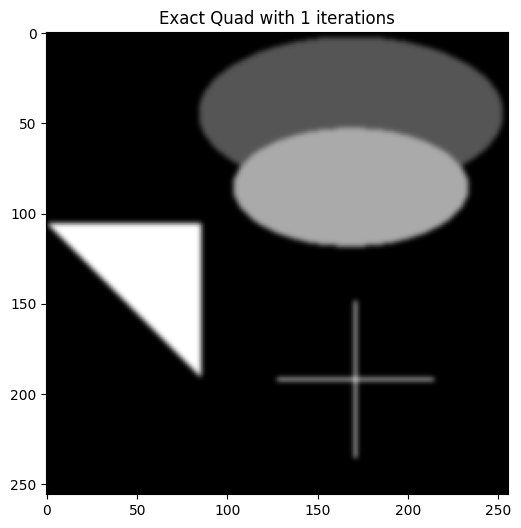

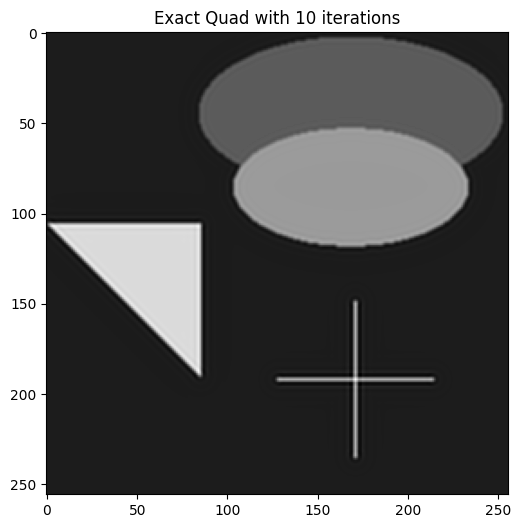

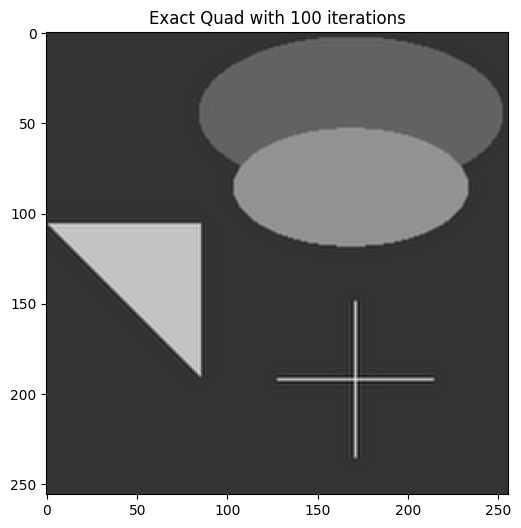

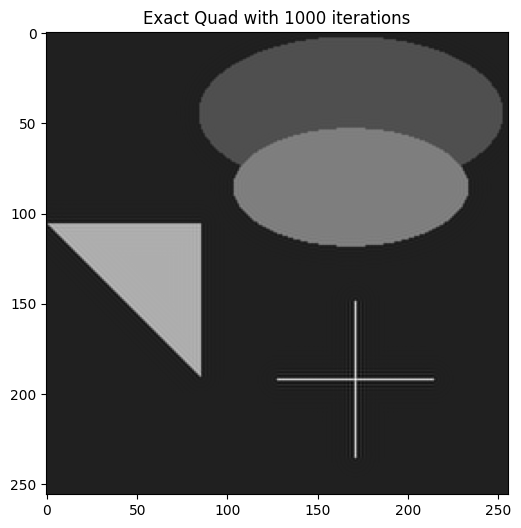

In [50]:
A_T = A.T
AT_A = A_T.dot(A)
f = lambda x: np.linalg.norm(A.dot(x)-b) ** 2
gf = lambda x: 2 * (AT_A.dot(x) - A_T.dot(b))
lsearch = exact_quad(A)
x0 = np.zeros(b.shape)
for iter_num in [1, 10, 100, 1000]:
    x, fs, ts = generic_grad(f, gf, lsearch, x0, iter_num)
    plt.figure(figsize=(6,6))
    plt.title("Exact Quad with " + str(iter_num) + " iterations")
    plt.imshow(x[-1].reshape(256 ,256), cmap='gray')
    plt.show()

## Section B


In [51]:
def const_step(s):
    def lsearch(f ,xk ,gk):
        return s
    return lsearch

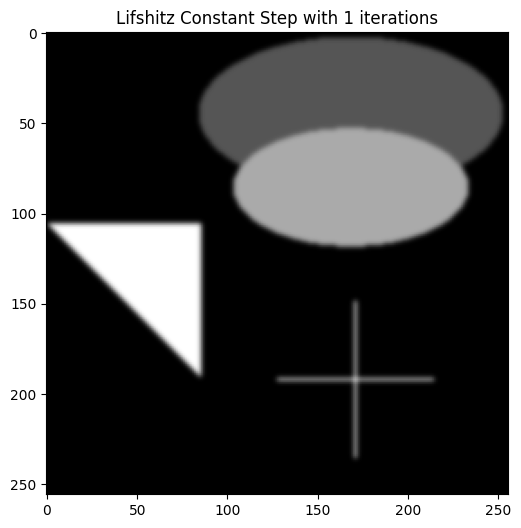

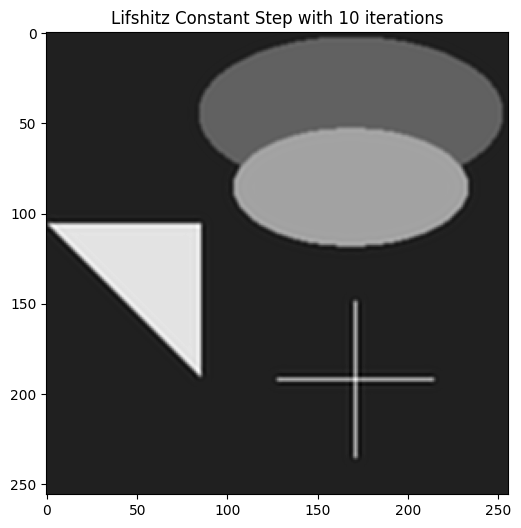

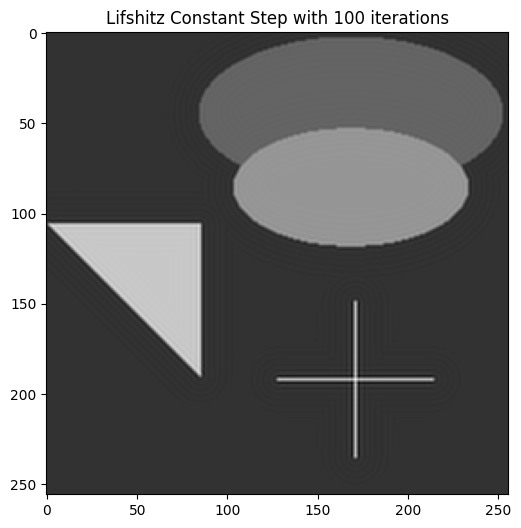

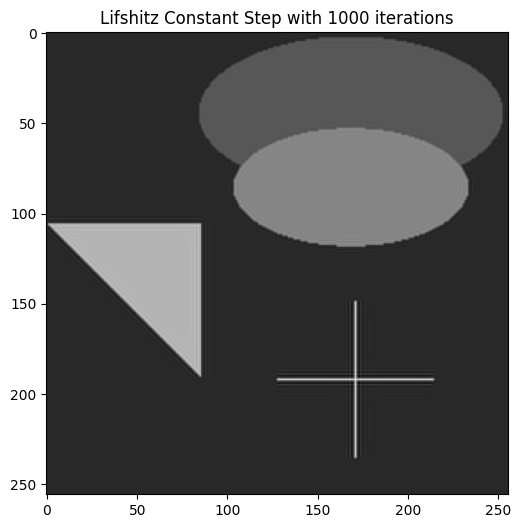

In [52]:
L= 2 * max(np.real(scipy.sparse.linalg.eigs(AT_A)[0]))
lsearch = const_step(1/L)
for iter_num in [1, 10, 100, 1000]:
    x_const, fs_const, ts_const = generic_grad(f, gf, lsearch, x0, iter_num)
    plt.figure(figsize=(6,6))
    plt.title("Lifshitz Constant Step with " + str(iter_num) + " iterations")
    plt.imshow(x_const[-1].reshape(256 ,256), cmap='gray')
    plt.show()

## Section C

In [53]:
import time

def AG(f, gf, L, x0, max_iter):
    y = [0, x0]
    x = [x0]
    fs, gs, ts = list(), list(), list()
    t = [0, 1]
    i = 1
    tic = time.time()
    while True:
        fs.append(f(x[i-1]))
        gs.append(np.linalg.norm(gf(x[i-1])))
        ts.append((time.time() - tic) * 1000)
        if i > max_iter:
            break
        x.append(y[i] - (1/L) * gf(y[i]))
        t.append(0.5 * (1 + np.sqrt(1 + 4 * t[i]**2)))
        y.append(x[i] + ((t[i] - 1) / t[i+1]) * (x[i] - x[i-1]))
        i += 1
    return x, fs, gs, ts

## Section D

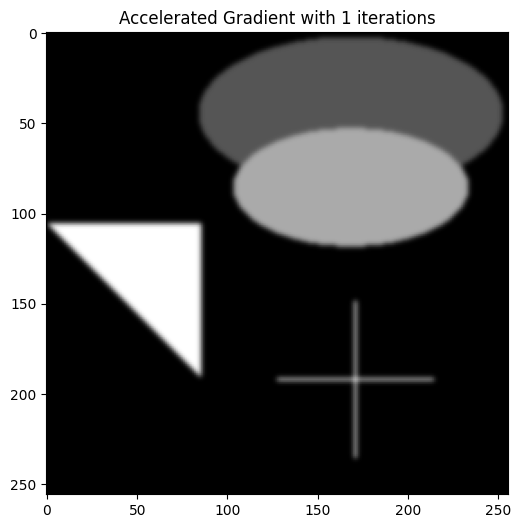

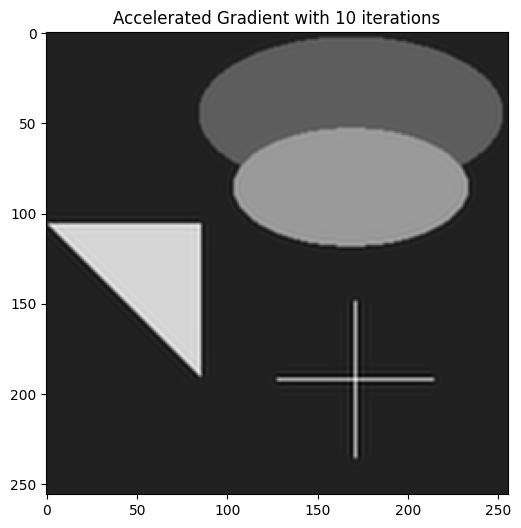

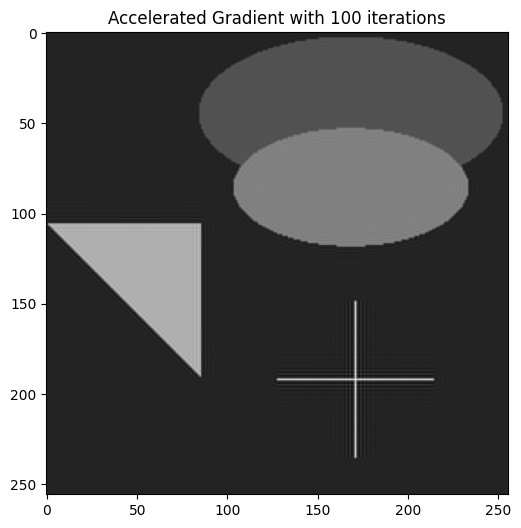

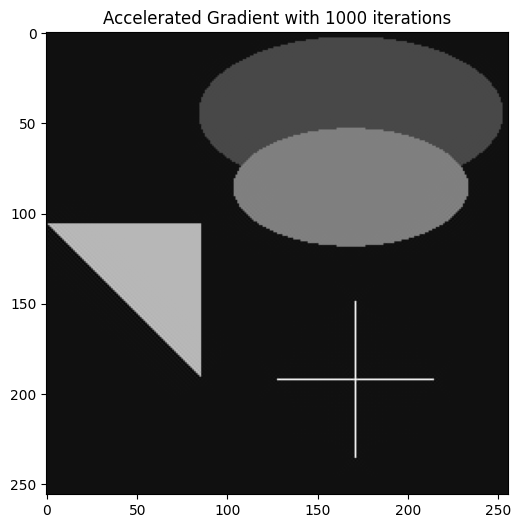

In [55]:
for iter_num in [1, 10, 100, 1000]:
    x_ag, fs_ag, _, ts_ag = AG(f, gf, L, x0, iter_num)
    plt.figure(figsize=(6,6))
    plt.title("Accelerated Gradient with " + str(iter_num) + " iterations")
    plt.imshow(x_ag[-1].reshape(256 ,256), cmap='gray')
    plt.show()

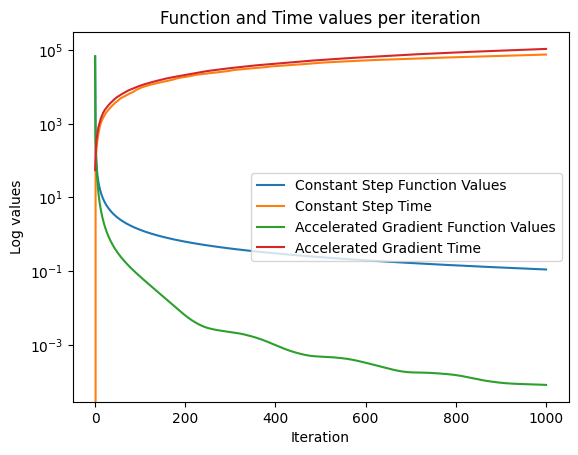

In [61]:
plt.semilogy(fs_const, label='Constant Step Function Values')
plt.semilogy(ts_const, label='Constant Step Time')
plt.semilogy(fs_ag, label='Accelerated Gradient Function Values')
plt.semilogy(ts_ag, label='Accelerated Gradient Time')
plt.xlabel('Iteration')
plt.ylabel('Log values')
plt.title('Function and Time values per iteration')
plt.legend()
plt.show()